# Import libraries

In [31]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

# Connect to database

In [2]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

# Retrieve relevant data from the database

In [4]:
query="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 84
"""

In [5]:
df = pd.read_sql_query(query, conn)

C:\Users\elian\AppData\Local\Temp\ipykernel_115060\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38070 entries, 0 to 38069
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38070 non-null  datetime64[ns]
 1   net_load  38070 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 595.0 KB


In [7]:
df

,ts,net_load
0,2019-03-01 00:00:00,24.58
1,2019-03-01 00:15:00,23.96
2,2019-03-01 00:30:00,25.38
3,2019-03-01 00:45:00,18.61
4,2019-03-01 01:00:00,15.59
...,...,...
38065,2020-03-31 22:45:00,356.50
38066,2020-03-31 23:00:00,348.87
38067,2020-03-31 23:15:00,270.94
38068,2020-03-31 23:30:00,57.65


In [8]:
# Convert 'ts' to datetime and set as index
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)

df

,net_load
ts,
2019-03-01 00:00:00,24.58
2019-03-01 00:15:00,23.96
2019-03-01 00:30:00,25.38
2019-03-01 00:45:00,18.61
2019-03-01 01:00:00,15.59
...,...
2020-03-31 22:45:00,356.50
2020-03-31 23:00:00,348.87
2020-03-31 23:15:00,270.94


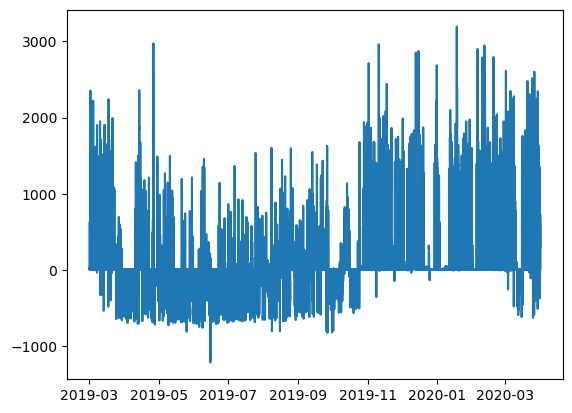

In [9]:
plt.plot(df.index, df.net_load)
plt.show()

# Normalise net load (used Min-Max Normalization but others could be explored e.g., Z-Score, robust, etc.)

In [10]:
# Normalise the 'net_load' values using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
df['net_load_norm'] = scaler.fit_transform(df[['net_load']])

df

,net_load,net_load_norm
ts,,
2019-03-01 00:00:00,24.58,-0.439338
2019-03-01 00:15:00,23.96,-0.439620
2019-03-01 00:30:00,25.38,-0.438975
2019-03-01 00:45:00,18.61,-0.442049
2019-03-01 01:00:00,15.59,-0.443420
...,...,...
2020-03-31 22:45:00,356.50,-0.288629
2020-03-31 23:00:00,348.87,-0.292093
2020-03-31 23:15:00,270.94,-0.327478


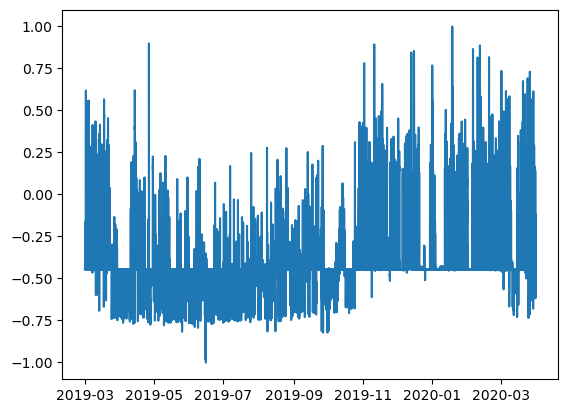

In [11]:
plt.plot(df.index, df.net_load_norm)
plt.show()

# Get time series data into a matrix that can be input into the LSTM model

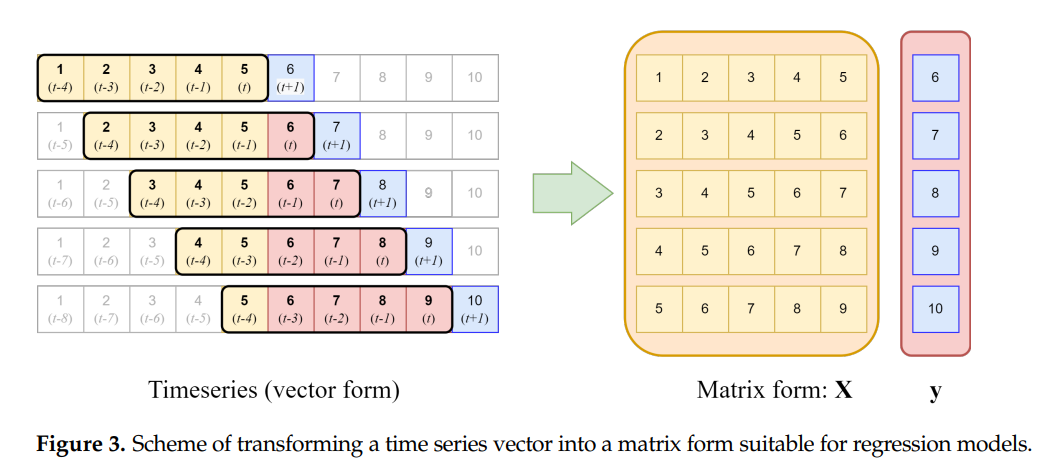

In [52]:
# Example
# Based on the first 5 hours, let's predict the 6th hour
# Based on the next 5 hours, let's predict the 7th hour
# etc. etc.

# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

# window_size is the number of previous time stamps that should be considered for the prediction

def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = np.lib.stride_tricks.sliding_window_view(df_as_np, window_shape=window_size)
    X = X.reshape(X.shape[0], X.shape[1], 1)  
    y = df_as_np[window_size:]
    return X, y

# 4 * hours * days
# 1 day window size
window_size = 4*24*7

X, y = df_to_X_y(df['net_load_norm'], window_size)

print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y value: \n {y[0]}')

Given the array X: 
 [-0.43933835 -0.43961987 -0.43897511 -0.44204906 -0.4434203  -0.43995133
 -0.43983327 -0.44009662 -0.44305252 -0.44416041 -0.44098203 -0.44021014
 -0.44053706 -0.44405144 -0.44407414 -0.44032365 -0.44026008 -0.44179025
 -0.44427846 -0.44294808 -0.44024192 -0.44052343 -0.44349749 -0.44436927
 -0.44126808 -0.44006938 -0.440755   -0.43764019 -0.43184192 -0.1638818
 -0.43218246 -0.44386981 -0.44569057 -0.44245316 -0.440419   -0.44337943
 -0.44571327 -0.435211   -0.44722527 -0.44739782 -0.44712992 -0.44740236
 -0.44760668 -0.44761122 -0.447139   -0.44751587 -0.44734787 -0.4469483
 -0.4481016  -0.44832863 -0.4472616  -0.44733425 -0.44741144 -0.44837403
 -0.44693468 -0.44739327 -0.44717079 -0.44762938 -0.44712538 -0.44707998
 -0.44729338 -0.44696646 -0.44747046 -0.44752495 -0.44769749 -0.44722073
 -0.44758398 -0.4472389  -0.44739782 -0.36020124 -0.18873219 -0.18153997
 -0.21215231 -0.22828031 -0.20846539 -0.01408022  0.1467912   0.12413389
  0.15036915  0.17657262  0.1468

# Split into train, test, val (train = 40 weeks, test = 1 day, val = 1 day)

In [53]:
def split_time_series(X, y, train_size, test_size, val_size, interval):

    train_end = train_size * interval
    test_end = train_end + test_size * interval

    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[train_end:test_end], y[train_end:test_end]
    X_val, y_val = X[test_end:test_end+val_size*interval], y[test_end:test_end+val_size*interval]

    return X_train, y_train, X_test, y_test, X_val, y_val

interval = 96  # no. of 15-min increments in 1 day

# Use the function to split your dataset
X_train, y_train, X_test, y_test, X_val, y_val = split_time_series(
    X, y,
    train_size=40*7,  # 40 weeks
    test_size=1,     # 1 day
    val_size=1,      # 1 day
    interval=interval
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((26880, 672, 1), (26880,), (96, 672, 1), (96,), (96, 672, 1), (96,))

# Build LSTM model

In [54]:
model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
cp1 = ModelCheckpoint('model3.keras', save_best_only=True)
model1.compile(loss='mae', optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError()])

# Fit LSTM model

In [56]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 96s 113ms/step - loss: 0.1713 - mean_absolute_error: 0.1713 - val_loss: 0.0022 - val_mean_absolute_error: 0.0022
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 88s 104ms/step - loss: 0.0396 - mean_absolute_error: 0.0396 - val_loss: 0.0027 - val_mean_absolute_error: 0.0027
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 101s 120ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - val_loss: 0.0022 - val_mean_absolute_error: 0.0022
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 101s 120ms/step - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0016 - val_mean_absolute_error: 0.0016
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 102s 122ms/step - loss: 0.0286 - mean_absolute_error: 0.0286 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.0013 - val_mean_absolute_error: 0.0013
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 101s 121ms/step - loss: 0.0267 - mean_a

# Check training results

In [57]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

train_results

840/840 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step


,Train Predictions,Actuals
0,-0.413679,-0.410996
1,-0.418641,-0.425285
2,-0.425965,-0.422806
3,-0.427744,-0.424577
4,-0.429014,-0.424854
...,...,...
26875,-0.441001,-0.443270
26876,-0.446267,-0.440977
26877,-0.446143,-0.440796
26878,-0.445394,-0.443883


Training MAE: 0.025270323448148748


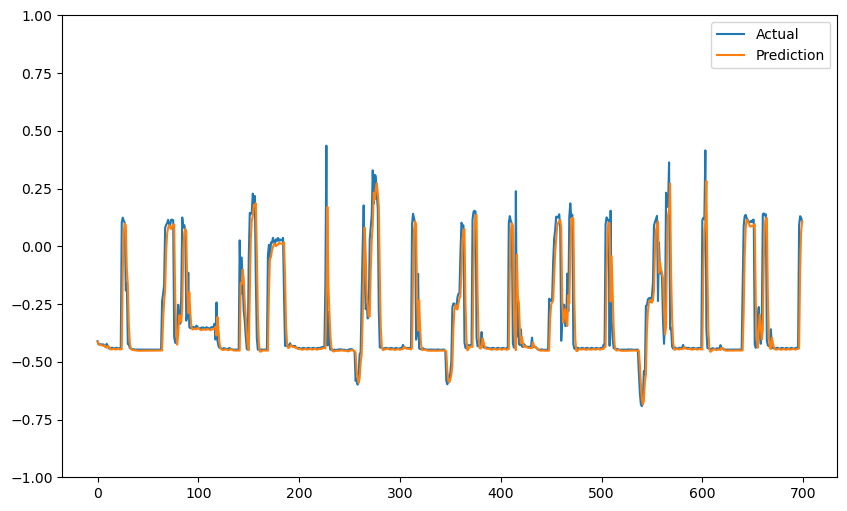

In [58]:
plt.figure(figsize=(10,6))
plt.plot(train_results['Actuals'][0:700], label='Actual')
plt.plot(train_results['Train Predictions'][0:700], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_train, train_predictions)}")

# Check validation results

In [59]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


,Val Predictions,Actuals
0,-0.445320,-0.441032
1,-0.445496,-0.443752
2,-0.447056,-0.449237
3,-0.451175,-0.446848
4,-0.451488,-0.445196
...,...,...
91,-0.444689,-0.443974
92,-0.446862,-0.444201
93,-0.448044,-0.441400
94,-0.446624,-0.441050


Training MAE: 0.0044309496910701065


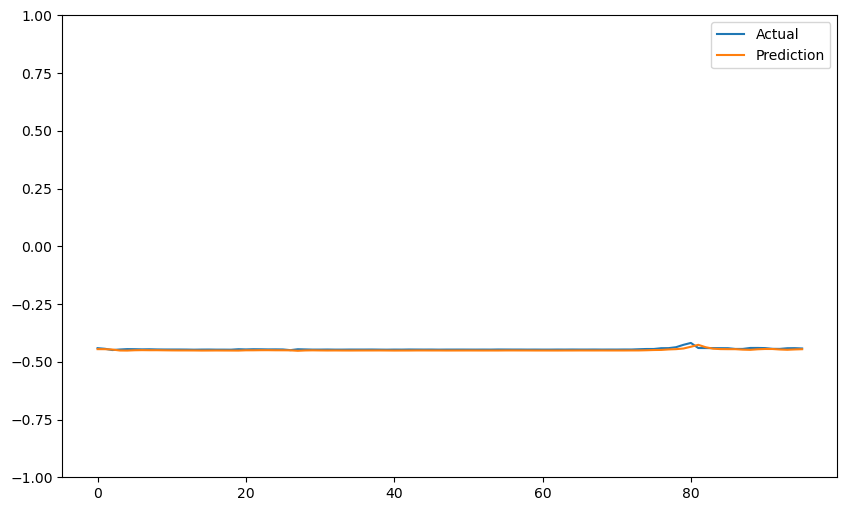

In [60]:
plt.figure(figsize=(10,6))
plt.plot(val_results['Actuals'], label='Actual')
plt.plot(val_results['Val Predictions'], label='Prediction')
plt.ylim((-1,1))
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_val, val_predictions)}")

# Check test results

In [61]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


,Test Predictions,Actuals
0,-0.278734,0.844795
1,0.405091,0.351034
2,0.418662,0.251700
3,0.303444,0.164999
4,0.195550,0.166956
...,...,...
91,-0.443621,-0.434634
92,-0.441116,-0.425789
93,-0.434017,-0.439615
94,-0.439466,-0.440555


Training MAE: 0.0341812863038167


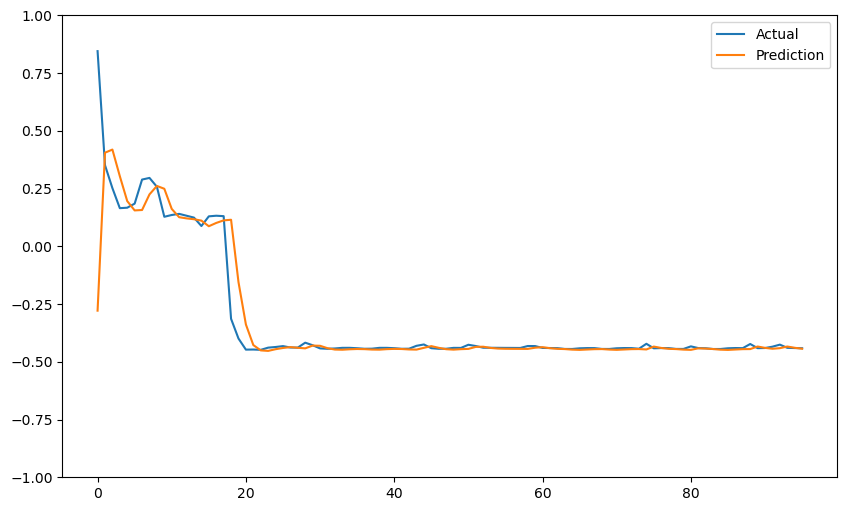

In [62]:
plt.figure(figsize=(10,6))
plt.plot(test_results['Actuals'], label='Actual')
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.ylim([-1,1])
plt.legend()

print(f"Training MAE: {mean_absolute_error(y_test, test_predictions)}")